In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rosbag
import pymap3d as pm
import numba as nb
import inspect
import cost as ct

from scipy.signal import savgol_filter
%matplotlib inline

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

@nb.njit()
def to_euler(x, y, z, w):
    """Dari Coursera: Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])
# Compile the to_euler
_ = to_euler(1.5352300785980803e-15, -1.3393747145983517e-15, -0.7692164172827881, 0.638988343698562)

In [3]:
def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]

# Import Data from a Bag File

In [4]:
class get_data_from_bag(object):
    def __init__(self, path):
        self.bag = rosbag.Bag(path)
        self.cs = self._read_msg_from_topic('/control_signal', ['t', 'action_throttle', 'action_steer',
                                                                'error_lateral', 'error_yaw','error_speed',
                                                                'actual_x','actual_y','actual_yaw','actual_speed',
                                                                'ref_x', 'ref_y', 'ref_yaw', 'ref_curvature', 'ref_speed',
                                                                'wp_idx'])
        self.ar = self._read_msg_from_topic('/logging_arduino', ['t', 'steering_setpoint', 'steering_angle', 'throttle_voltage'])
        
    def _read_msg_from_topic(self, topic, columns_name):
        data = []
        for _, msg, _ in self.bag.read_messages(topics=[topic]):
            temp = []
            for name in columns_name:
                if name == 't':
                    temp.append(msg.header.stamp.to_sec())
                else:
                    nm = 'msg.' + name
                    temp.append(eval(nm))
            data.append(temp)
        return pd.DataFrame(data, columns = columns_name)

In [5]:
sl1 = get_data_from_bag('STANLEY/LURUS_1.bag')
sl2 = get_data_from_bag('STANLEY/LURUS_2.bag')
sl3 = get_data_from_bag('STANLEY/LURUS_3.bag')
sl4 = get_data_from_bag('STANLEY/LURUS_4.bag')
ss1 = get_data_from_bag('STANLEY/S_1.bag')
ss2 = get_data_from_bag('STANLEY/S_2.bag')
ss3 = get_data_from_bag('STANLEY/S_3.bag')
ss4 = get_data_from_bag('STANLEY/S_4.bag')
ss5 = get_data_from_bag('STANLEY/S_5.bag')
ss6 = get_data_from_bag('STANLEY/S_6.bag')
sb1 = get_data_from_bag('STANLEY/BELOK_1.bag')
sb2 = get_data_from_bag('STANLEY/BELOK_2.bag')
sb3 = get_data_from_bag('STANLEY/BELOK_3.bag')

In [6]:
pl1 = get_data_from_bag('PID/LURUS_PID_1.bag')
pl2 = get_data_from_bag('PID/LURUS_PID_2.bag')
pl3 = get_data_from_bag('PID/LURUS_PID_3.bag')
ps1 = get_data_from_bag('PID/S_PID_1.bag')
ps2 = get_data_from_bag('PID/S_PID_2.bag')
ps3 = get_data_from_bag('PID/S_PID_3.bag')
pb1 = get_data_from_bag('PID/BELOK_PID_1.bag')
pb2 = get_data_from_bag('PID/BELOK_PID_2.bag')
pb3 = get_data_from_bag('PID/BELOK_PID_3.bag')

# PLOT

In [7]:
def additional_plot(o1, fig_name, lim, lim_fil, lim_e_lat, lim_e_yaw):
    srx = o1.cs.ref_x
    sry = o1.cs.ref_y
    sx = o1.cs.actual_x
    sy = o1.cs.actual_y
    
    a = np.min(np.array([srx, sry]).T, axis=0)
    b = np.min(np.array([sx, sy]).T, axis=0)
    min_val = np.min(np.array([a,b]), axis=0)

    a = np.max(np.array([srx, sry]).T, axis=0)
    b = np.max(np.array([sx, sy]).T, axis=0)
    max_val = np.max(np.array([a,b]), axis=0)

    center = (max_val + min_val) / 2
    scale = max_val - min_val
    max_scale = np.max(scale)

    lim_min = center - max_scale/1.9
    lim_max = center + max_scale/1.9
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))
    ax1.plot(srx, sry, label='Referensi', linewidth=3., color='tab:orange')
    ax1.plot(sx, sy, label='Aktual', linestyle='--', linewidth=1.5, color='black')
    ax1.set_xlim(lim_min[0], lim_max[0])
    ax1.set_ylim(lim_min[1], lim_max[1])
    ax1.set_xlabel("X (m)", fontsize=15)
    ax1.set_ylabel("Y (m)", fontsize=15)
    ax1.legend(fontsize=15)
    ax1.set_title('Profil Lintasan dan Posisi', fontsize=20)
    ax1.tick_params(axis="x", labelsize=14) 
    ax1.tick_params(axis="y", labelsize=14) 
    
    for i in range(1, o1.ar.t.shape[0]):
        if np.abs(o1.ar.steering_angle[i] - o1.ar.steering_angle[i-1]) >= lim_fil:
            o1.ar.steering_angle[i] = o1.ar.steering_angle[i-1]
    ax2.plot(o1.cs.t - o1.cs.t[0], o1.cs.action_steer, label='Perintah')
    ax2.plot(o1.ar.t - o1.cs.t[0], o1.ar.steering_angle, label='Aktual')
    ax2.set_ylim(min(lim), max(lim))
    ax2.set_xlim(0., None)
    ax2.set_xlabel("Waktu (s)", fontsize=15)
    ax2.set_ylabel(r"Sudut Kemudi $(\degree)$", fontsize=15)
    ax2.legend(fontsize=15)
    ax2.set_title('Profil Sudut Kemudi', fontsize=20)
    ax2.tick_params(axis="x", labelsize=14) 
    ax2.tick_params(axis="y", labelsize=14) 
    
    ax3.plot(o1.cs.t - o1.cs.t[0], o1.cs.error_lateral, color='black')
    ax3.set_xlabel("Waktu (s)", fontsize=15)
    ax3.set_ylabel("Galat Lateral (m)", color='black', fontsize=15)
    ax3.set_ylim(min(lim_e_lat), max(lim_e_lat))
    ax3.set_title('Profil Galat Lateral dan Yaw', fontsize=20)
    ax3.tick_params(axis="x", labelsize=14) 
    ax3.tick_params(axis="y", labelsize=14) 
    
    ax4 = ax3.twinx()
    ax4.plot(o1.cs.t - o1.cs.t[0], o1.cs.error_yaw*180./np.pi, color='tab:red')
    ax4.set_ylabel(r"Galat Yaw $(\degree)$", color='tab:red', fontsize=15)
    ax4.set_ylim(min(lim_e_yaw), max(lim_e_yaw))
    ax4.tick_params(axis="x", labelsize=14) 
    ax4.tick_params(axis="y", labelsize=14) 
    
    plt.savefig('img_v2/'+fig_name+'.png', dpi=600, bbox_inches='tight', transparent=True)
    plt.show()

In [8]:
# Yang Gak Perlu di PLOT

# sl1 pl1
# sl4 pl3
# ss2 ps2
# ss3 ps1
# sb1 pb2

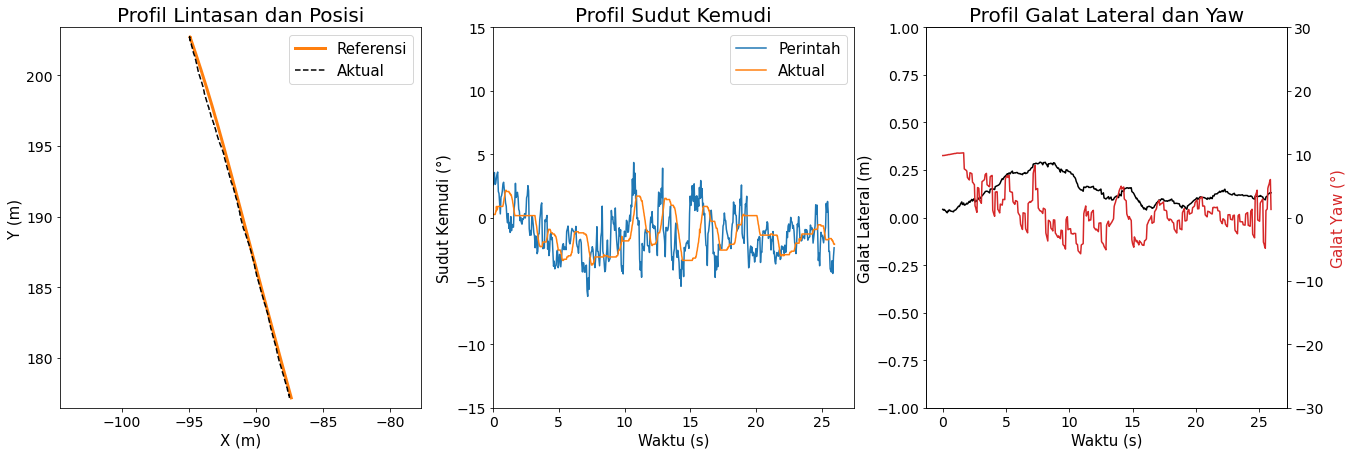

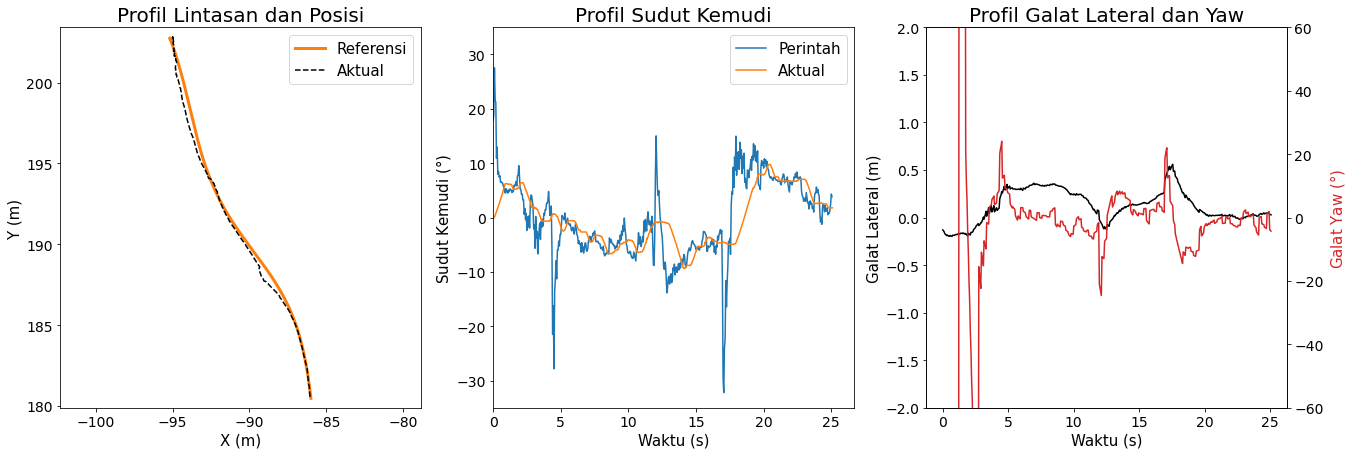

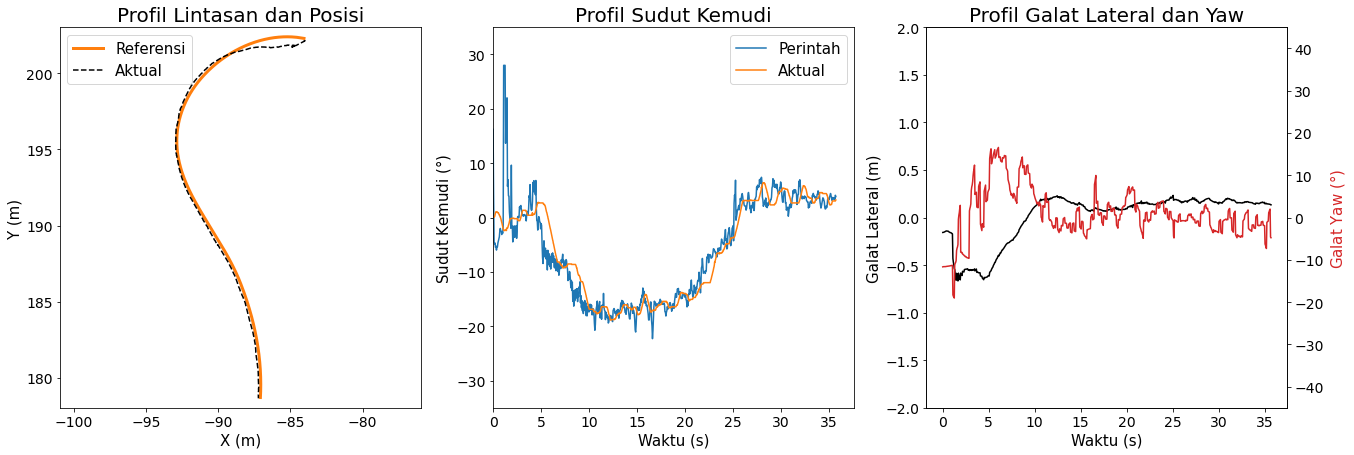

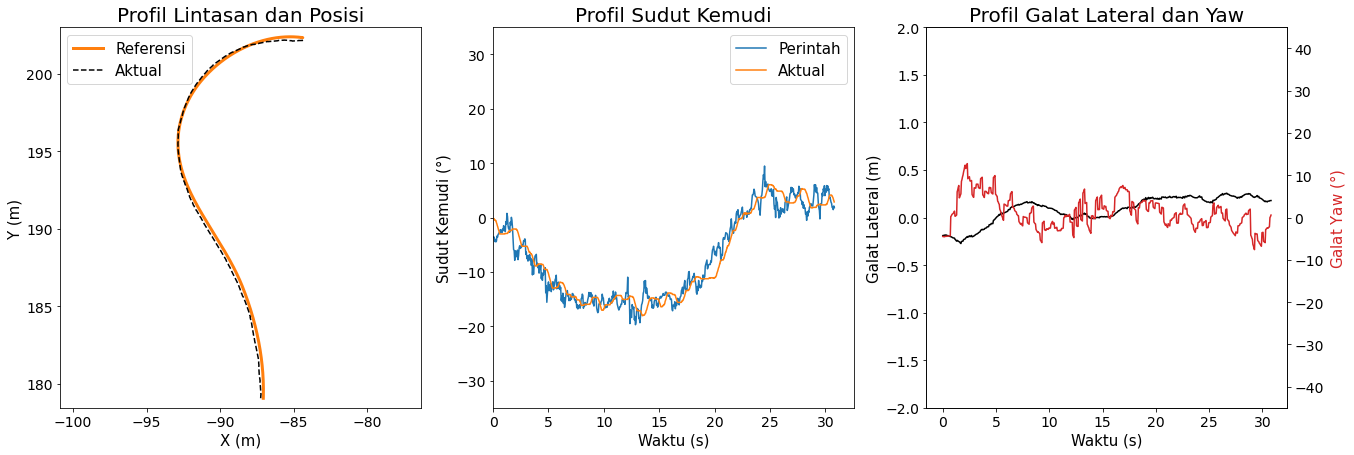

In [9]:
additional_plot(pl2, 'pl2', [-15., 15.], 0.5, [-1, 1], [-30., 30.])
additional_plot(ps3, 'ps3', [-35., 35.], 0.5, [-2, 2], [-60., 60.])
additional_plot(pb1, 'pb1', [-35., 35.], 0.5, [-2, 2], [-45., 45.])
additional_plot(pb3, 'pb3', [-35., 35.], 0.5, [-2, 2], [-45., 45.])

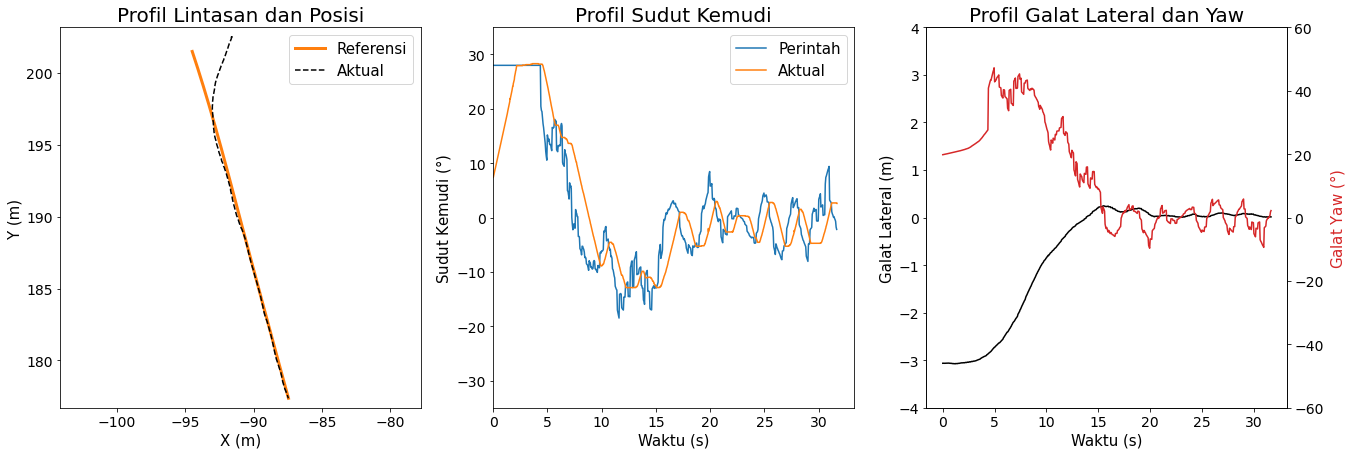

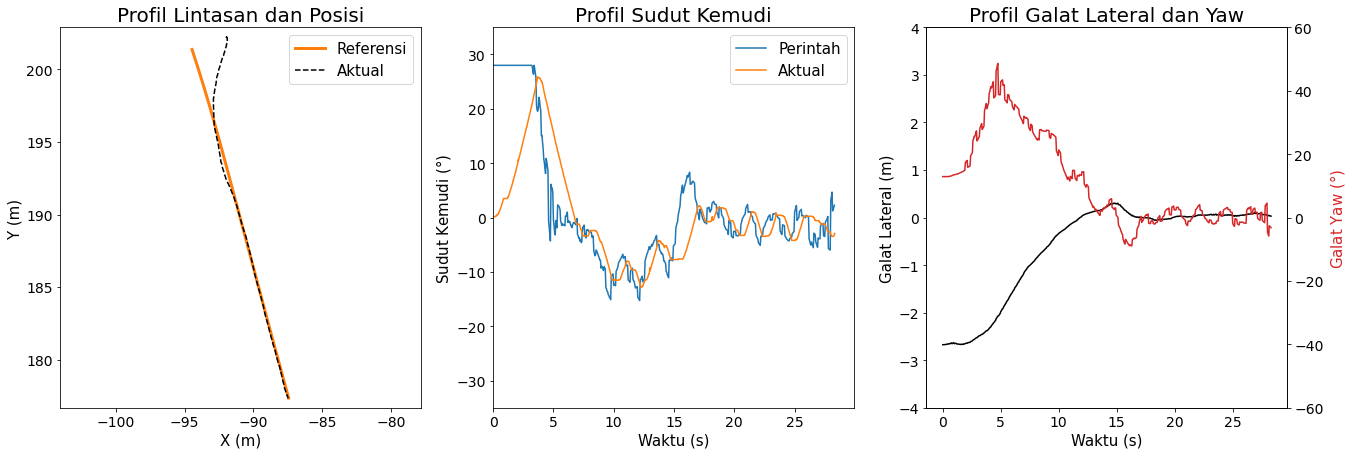

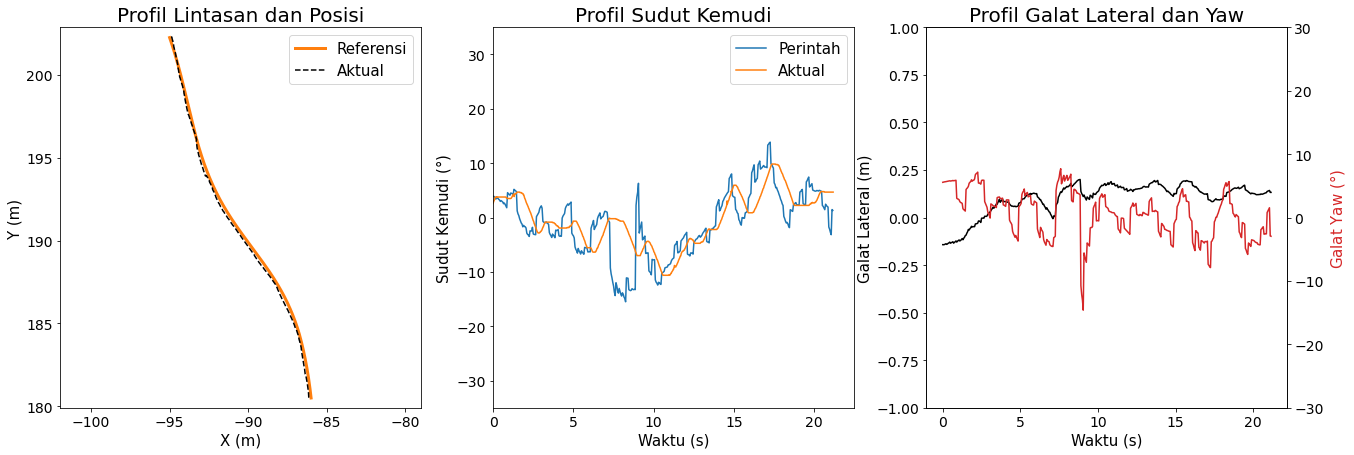

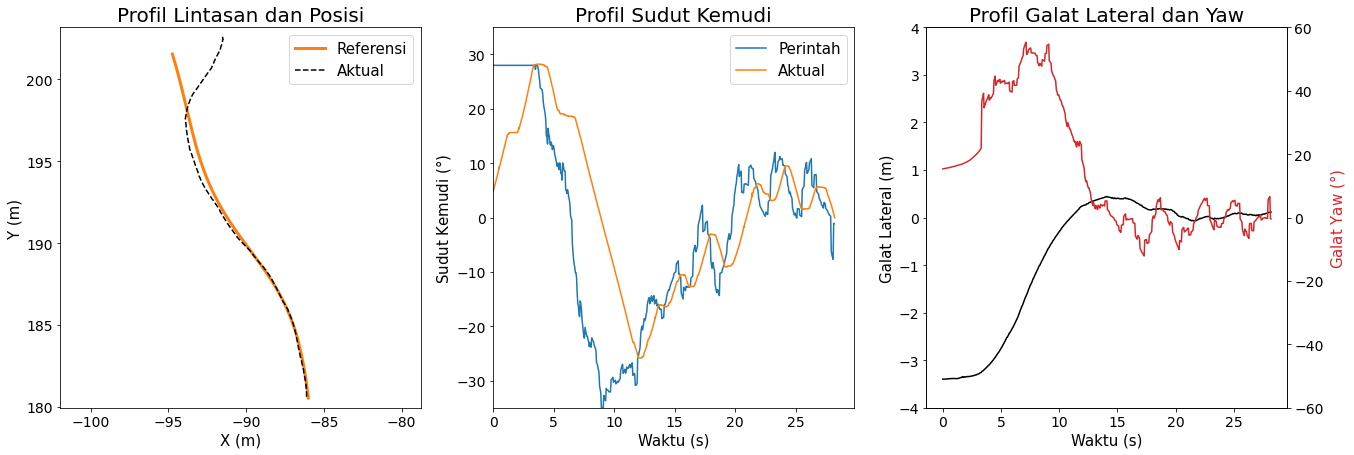

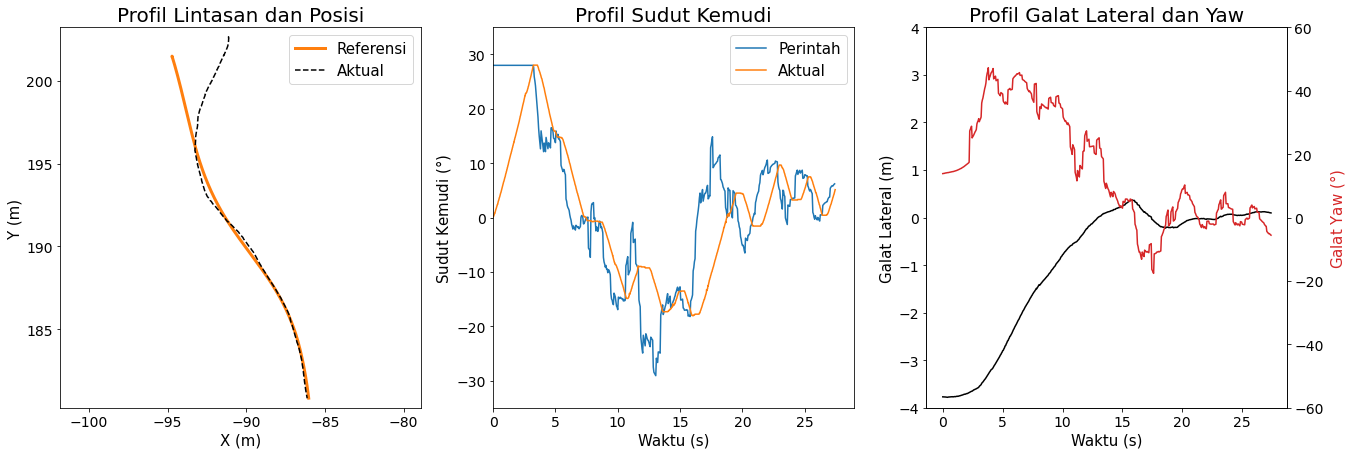

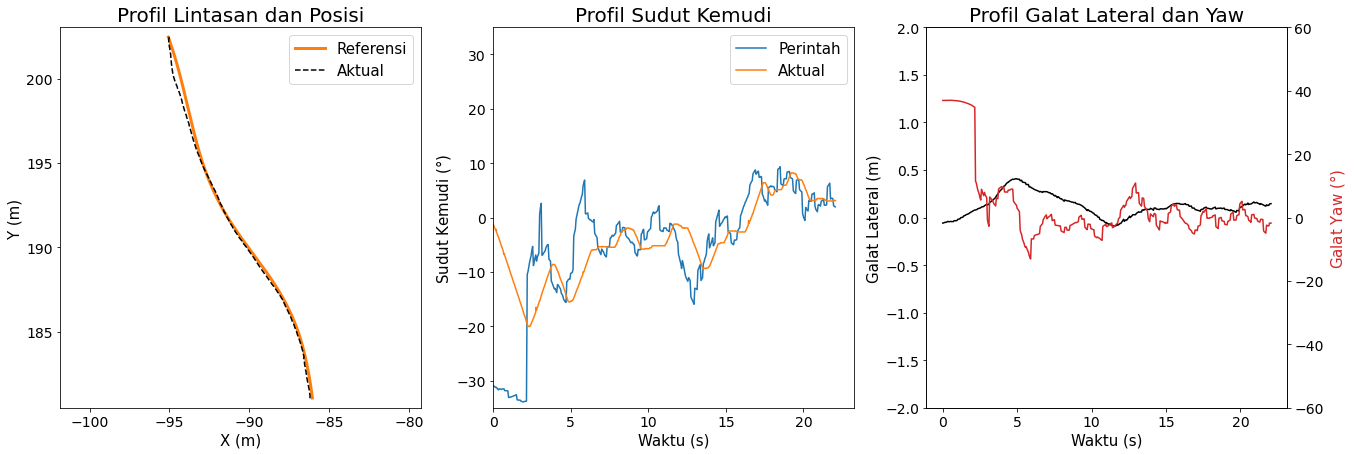

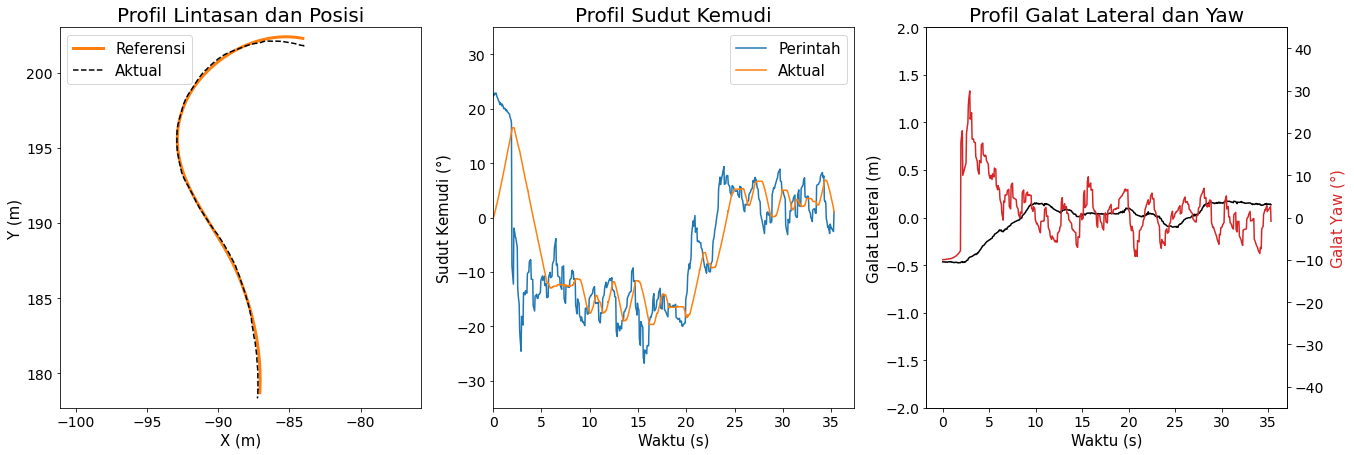

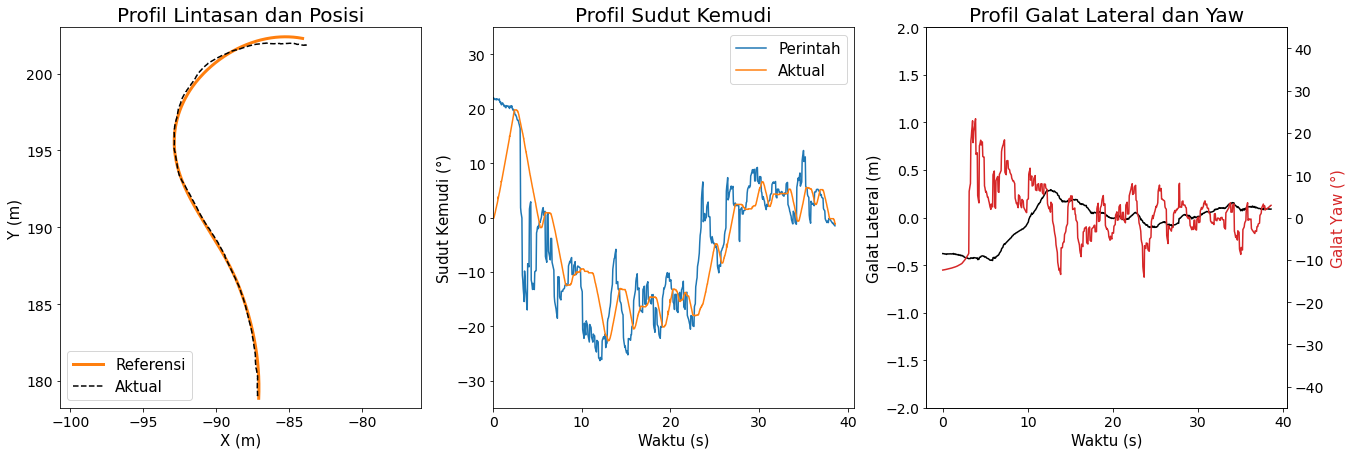

In [10]:
# additional_plot(sl1, 'sl1', [-15., 15.], 1.5, [-1, 1], [-30., 30.])
additional_plot(sl2, 'sl2', [-35., 35.], 1., [-4, 4], [-60., 60.])
additional_plot(sl3, 'sl3', [-35., 35.], 1., [-4, 4], [-60., 60.])
# additional_plot(sl4, 'sl4', [-35., 35.], 1.5, [-4, 4], [-70., 70.])
additional_plot(ss1, 'ss1', [-35., 35.], 1., [-1, 1], [-30., 30.])
# additional_plot(ss2, 'ss2', [-25., 25.], 1.5, [-1, 1], [-30., 30.])
# additional_plot(ss3, 'ss3', [-35., 35.], 1.5, [-4, 4], [-60., 60.])
additional_plot(ss4, 'ss4', [-35., 35.], 1., [-4, 4], [-60., 60.])
additional_plot(ss5, 'ss5', [-35., 35.], 1., [-4, 4], [-60., 60.])
additional_plot(ss6, 'ss6', [-35., 35.], 1., [-2, 2], [-60., 60.])
# additional_plot(sb1, 'sb1', [-35., 35.], 1.5, [-2, 2], [-45., 45.])
additional_plot(sb2, 'sb2', [-35., 35.], 1., [-2, 2], [-45., 45.])
additional_plot(sb3, 'sb3', [-35., 35.], 1., [-2, 2], [-45., 45.])